In [1]:
from keras.regularizers import l2
from lib.data.utils import train_data, targets, features, split_dataframe
from lib.data.windowed_data import WTSMaker
from lib.data.plot import plot_predictions
from lib.models.estimators import PollutionEstimator
from lib.models.on_the_fly import OnTheFlyLSTM
# from lib.models import DirectRnn
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier


import tensorflow as tf
import keras
from keras.callbacks import TensorBoard as TB, EarlyStopping as ES, ReduceLROnPlateau as RLRP
from keras.optimizers import Adam, SGD
import keras_tuner as kt
import seaborn as sns
sns.set_theme("notebook", style="whitegrid", rc={"figure.dpi": 100})

data_dir = "../data/"

df = train_data(data_dir, delta=False)
# in_day_features = CalendarFourier("D", 8)
# time_features = DeterministicProcess(
#     df.to_period("H").index,
#     constant=False,
#     additional_terms=[in_day_features],
#     drop=True
# ).in_sample().to_timestamp()

# df = df.join(time_features, how="left")
all_features = features  # + time_features.columns.to_list()

train_df, valid_df = split_dataframe(df, 0.2, 0.0)
(X_train, X_valid), (y_train, y_valid) = ([td[all_features] for td in train_df], valid_df[all_features]), ([
    td[targets] for td in train_df], valid_df[targets])

l = l2(0.01)
rnn_kwargs = {"dropout": 0.1, "recurrent_dropout": 0.1,
              "kernel_regularizer": l, "recurrent_regularizer": l, "bias_regularizer": l, "activity_regularizer": l}


def model_builder(hp):
    double_rnn = hp.Boolean("double_rnn")
    input_days = hp.Int("input_days", min_value=1, max_value=7, step=1)
    n_recursive_units = hp.Int("n_units", min_value=8, max_value=128, step=2, sampling="log")
    if double_rnn:
        second_layer = [3]
    else:
        second_layer = []
    model = OnTheFlyLSTM(len(all_features), len(targets), n_recursive_units=(
        [n_recursive_units] + second_layer), rnn_kwargs=rnn_kwargs, input_days=input_days)
    estimator = PollutionEstimator(all_features, targets, model, deltas=False)
    lr = hp.Float("learning_rate", min_value=1e-4, max_value=5e-2, sampling="log")
    la = hp.Choice("learning_algorithm", values=["adam", "sgd", "rmsprop"])
    estimator.adapt_training(train_df)
    estimator.compile(optimizer=keras.optimizers.deserialize(
        {"class_name": la, "config": {"learning_rate": lr, "clipnorm": 1_000.0}}), loss="mse")
    return estimator


In [2]:
with tf.device("/CPU:0"):
    tuner = kt.Hyperband(model_builder, objective="val_loss", max_epochs=500,
                         directory="tuning", project_name="on_the_fly_lstm", executions_per_trial=3)
    tuner.search(X=X_train, y=y_train, validation_data=valid_df, shift_hours=1, batch_size=32, callbacks=[ES(patience=100)])


Trial 53 Complete [00h 01m 29s]
val_loss: 1018.8871256510416

Best val_loss So Far: 836.1970418294271
Total elapsed time: 01h 02m 33s

Search: Running Trial #54

Value             |Best Value So Far |Hyperparameter
True              |True              |double_rnn
7                 |6                 |input_days
32                |32                |n_units
0.0012878         |0.0046483         |learning_rate
adam              |rmsprop           |learning_algorithm
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
5                 |5                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3
173/173 [==============================] - 14s 64ms/step - loss: 6440.4297 - val_loss: 2287.2327
Epoch 2/3
 67/173 [==========>...................] - ETA: 6s - loss: 3055.5649

In [10]:
with tf.device("/CPU:0"):
    n_units = [64]
    itd = [2]
    models = [OnTheFlyLSTM(len(all_features), len(targets), n_recursive_units=[nu, 3], rnn_kwargs=rnn_kwargs, input_days=d, name=f"n{nu}/id{d}") for nu in n_units for d in itd]
    estimators = [PollutionEstimator(all_features, targets, model, deltas=False, name=model.name) for model in models]
    for e in estimators:
        name = f"otf_dblrnn_regul/adam/{e.name}"
        e.adapt_training(train_df)
        e.compile(optimizer="adam", loss="mse")
        e.train(train_df, epochs=2000, validation_data=valid_df, shift_hours=1, batch_size=32, callbacks=[
            TB(f"../logs/{name}"), ES(patience=100, restore_best_weights=False)])


Epoch 1/2000
177/177 [==============================] - 7s 27ms/step - loss: 6206.1904 - val_loss: 2443.9819
Epoch 2/2000
177/177 [==============================] - 5s 25ms/step - loss: 3472.6023 - val_loss: 2869.3140
Epoch 3/2000
177/177 [==============================] - 5s 25ms/step - loss: 2832.0469 - val_loss: 1952.4790
Epoch 4/2000
177/177 [==============================] - 5s 24ms/step - loss: 2532.3438 - val_loss: 1882.6429
Epoch 5/2000
177/177 [==============================] - 5s 24ms/step - loss: 2296.3772 - val_loss: 2007.6414
Epoch 6/2000
177/177 [==============================] - 5s 24ms/step - loss: 2229.2566 - val_loss: 2058.9548
Epoch 7/2000
177/177 [==============================] - 5s 24ms/step - loss: 2074.4229 - val_loss: 1938.5055
Epoch 8/2000
177/177 [==============================] - 5s 24ms/step - loss: 1935.1864 - val_loss: 2034.8918
Epoch 9/2000
177/177 [==============================] - 5s 24ms/step - loss: 1824.3511 - val_loss: 2073.0435
Epoch 10/2000
177/1

KeyboardInterrupt: 

2023-04-14 23:29:03.949319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-14 23:29:04.096200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 724ms/step


2023-04-14 23:29:04.315802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


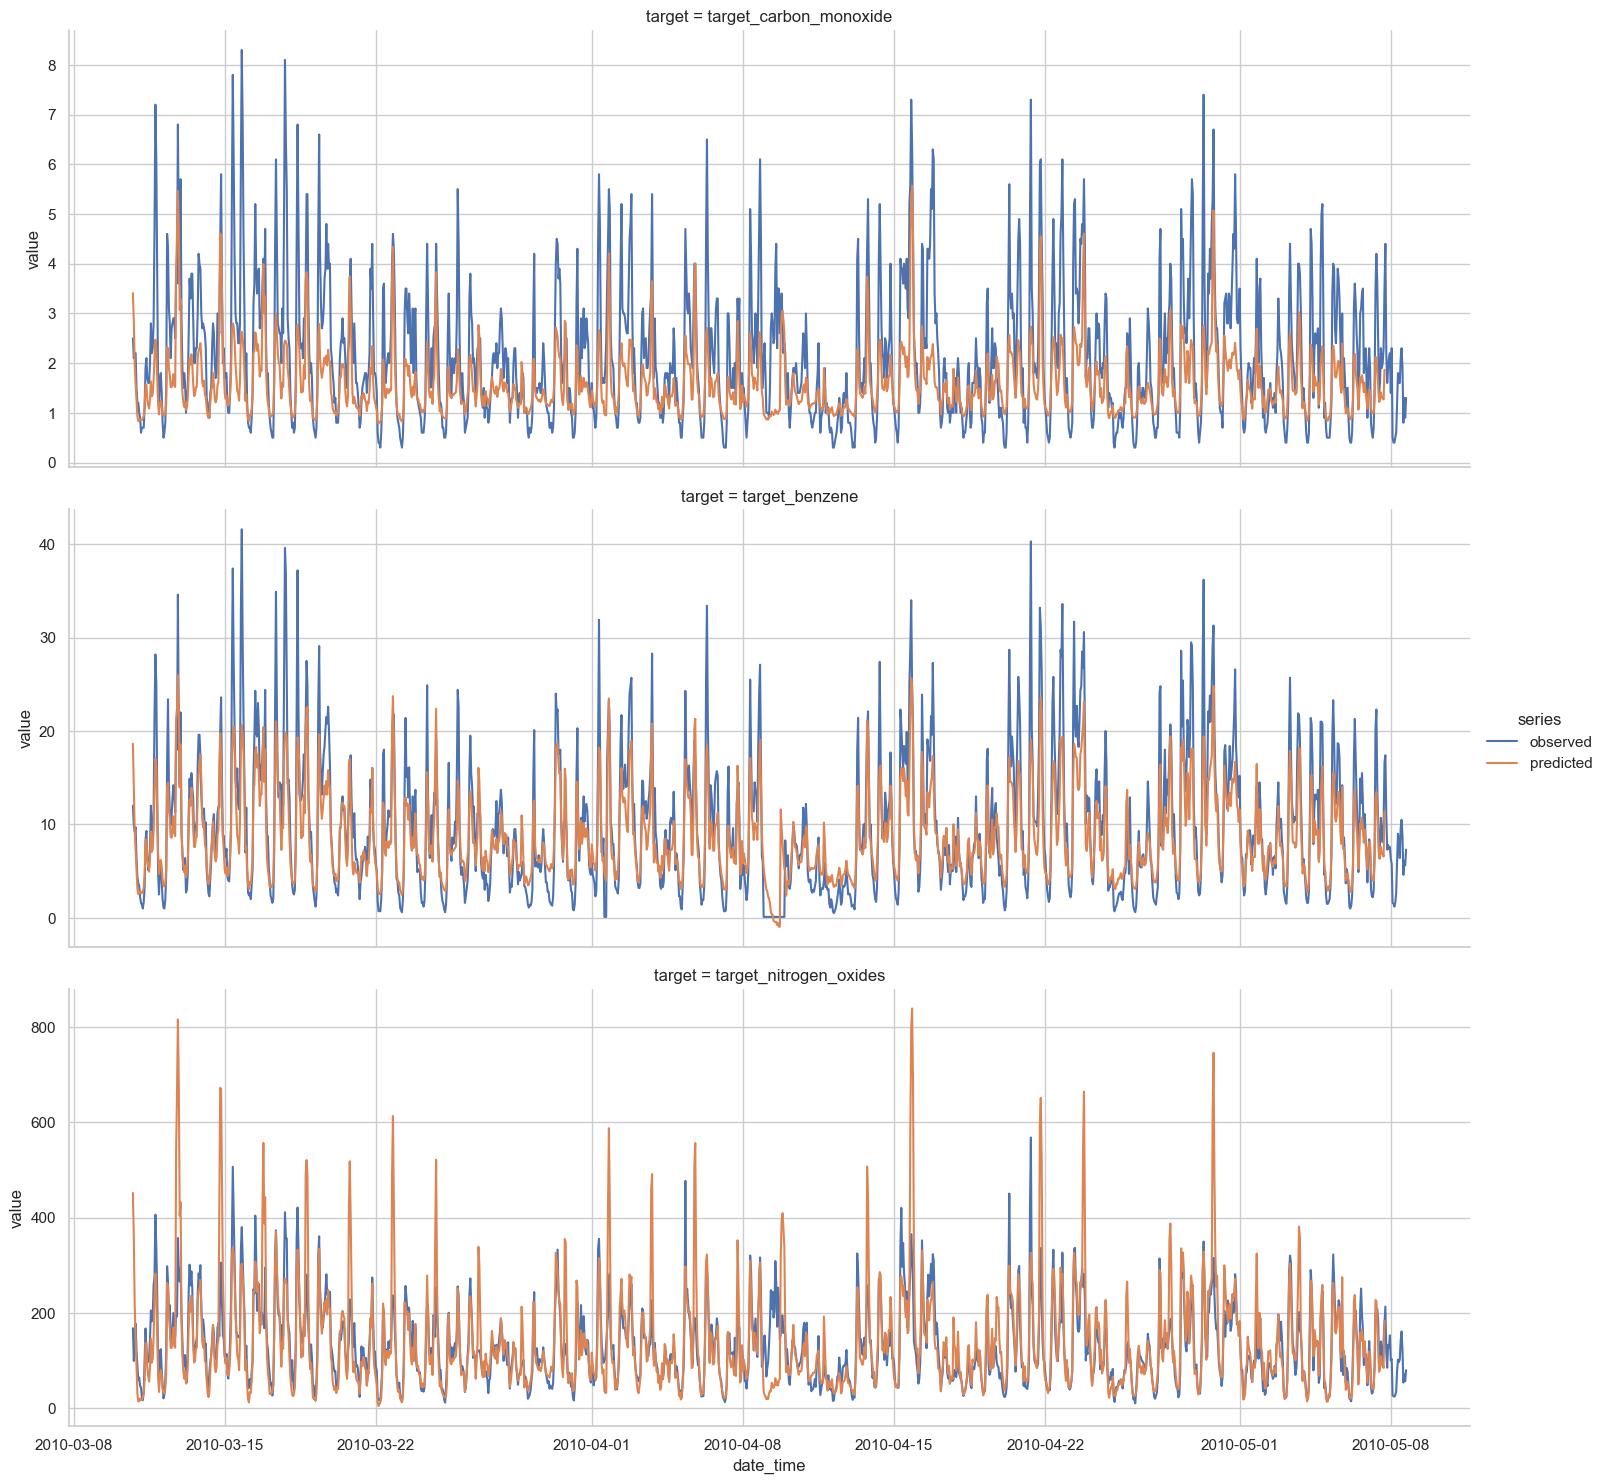

In [11]:
fg = plot_predictions(valid_df, estimators[0], aspect=3, facet_kws={
                      "sharey": False})  # , "xlim": (pd.Timestamp("2010-12-15"), pd.Timestamp("2010-12-25"))})


In [29]:
estimators[0].assess(valid_df, "mse")


1/1 [==============================] - 0s 50ms/step - loss: 807.6882


KeyError: 'mse'

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(train_df[all_features], train_df[targets])
